## Overview

We'll do an objective Bayesian analysis of a data set consisting of log zinc concentrations (ppm) sampled across a flood plain of the Meuse river using a Gaussian process model of the form

\begin{align*}
\mathbb{E}\left\{Z(\boldsymbol{s})\right\} &= \beta_1 + 
      \beta_2 x_1(\boldsymbol{s})\\
\mathrm{Cov}\left\{Z(\boldsymbol{s}), Z(\boldsymbol{u})\right\} &= 
    \sigma^2\left[\exp\left\{-\frac{1}{\theta}\left\|\boldsymbol{s}-\boldsymbol{u}\right\|\right\} + \eta\right],
\end{align*}

where $x_1(\boldsymbol{s})$ represents the square root of the distance from $\boldsymbol{s}$ to the river.

The data is part of the sp R-library 

*Pebesma Edzer J., Bivand Roger S.* Classes and methods for spatial data in R
// R News. November 2005. 5, 2. 9–13.

For the analysis, we use the reference prior from 

*Ren Cuirong, Sun Dongchu, He Chong*. [Objective Bayesian analysis for a spatial
model with nugget effects](https://www.sciencedirect.com/science/article/pii/S0047259X1300242X?via%3Dihub) // Journal of Statistical Planning and Inference.
2012. 142, 7. 1933–1946.

together with the deterministic inference algorithm from https://buildingblock.ai/bayesian-gaussian-process.pdf.

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from bbai.gp import BayesianGaussianProcessRegression, Power1CovarianceFunction
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
import time
import rdata
import requests
import tempfile

## Load Data Set

In [2]:
def read_file(url):
    tfile = tempfile.NamedTemporaryFile()
    tfile.write(requests.get(url).content)
    parsed = rdata.parser.parse_file(tfile.name)
    return rdata.conversion.convert(parsed)

In [3]:
# Read training data
url = 'https://github.com/edzer/sp/raw/main/data/meuse.rda'
df = read_file(url)['meuse']
df = df[['x', 'y', 'dist', 'zinc']]
Z_train = np.array(df.iloc[:, :2]) / 1.0e3
y_train = np.log(np.array(df.iloc[:, -1]))
dist = df.iloc[:, 2:3]
X_train = np.hstack((np.ones((len(Z_train), 1)), np.sqrt(dist)))

In [4]:
# Read test data
url = 'https://github.com/edzer/sp/raw/main/data/meuse.grid.rda'
df = read_file(url)['meuse.grid']
df = df[['x', 'y', 'dist']]
Z_test = np.array(df.iloc[:, :2]) / 1.0e3
dist = df.iloc[:, 2:3]
X_test = np.hstack((np.ones((len(Z_test), 1)), np.sqrt(dist)))

Text(0.5, 1.0, 'Sampling Locations')

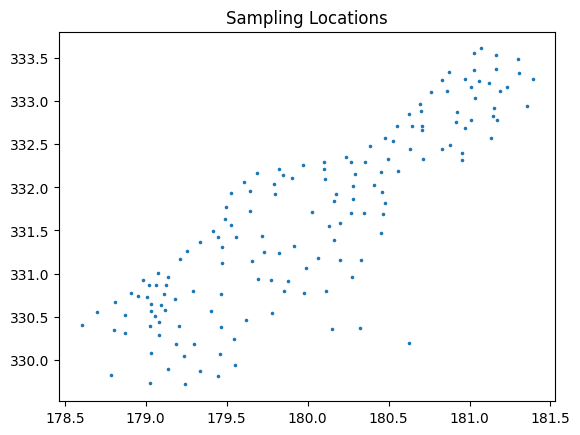

In [5]:
plt.scatter(Z_train[:, 0], Z_train[:, 1], s=2.5)
plt.title("Sampling Locations")

Text(0.5, 1.0, 'Prediction Locations')

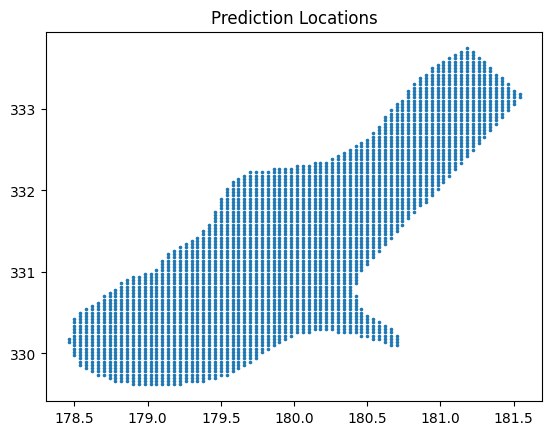

In [6]:
plt.scatter(Z_test[:, 0], Z_test[:, 1], s=2.5)
plt.title("Prediction Locations")

## Fit Model
Using a trust-region optimizer together with exact equations for the value, gradient, and hessian, we find parameters that maximize the posterior probability; then we construct a sparse-grid to interpolate the posterior distribution over a region bracketing the posterior mass up to a small tolerance.

See Step 1-4 of Section 4 of https://buildingblock.ai/bayesian-gaussian-process.pdf.

In [7]:
model = BayesianGaussianProcessRegression(kernel=Power1CovarianceFunction())
t1 = time.time()
model.fit(Z_train, y_train, X_train)
t2 = time.time()
print('elapse: ', t2 - t1)

elapse:  2.332462787628174


## Plot Sparse Grid
Visualize the sparse grid used to interpolate the posterior distribution.

See Step 4 of Section 4 of https://buildingblock.ai/bayesian-gaussian-process.pdf.

Text(0, 0.5, 'Log Noise Ratio')

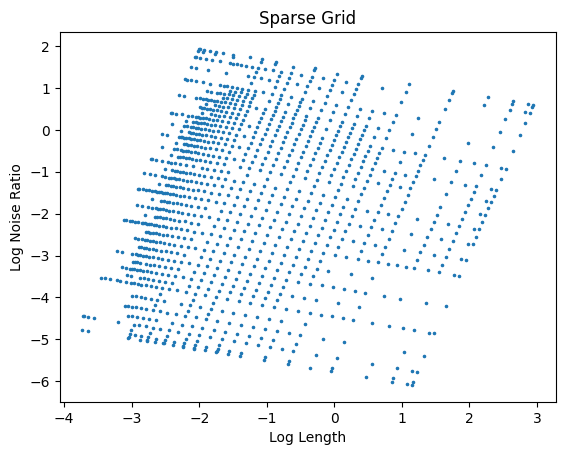

In [8]:
plt.scatter(model.hyperparameter_matrix_[0, :], model.hyperparameter_matrix_[1, :], s=2.5)
plt.title('Sparse Grid')
plt.xlabel('Log Length')
plt.ylabel('Log Noise Ratio')

## Plot posterior marginals
Visualize the posterior distribution for each parameter after integrating out the other parameters.

median length = 0.21885776179622937


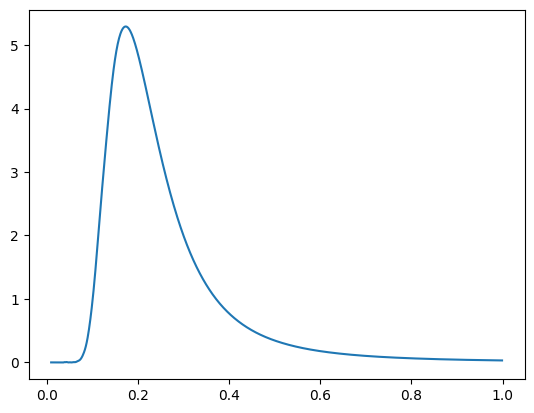

In [9]:
m = model.marginal_length_
lx = np.arange(0.01, 1, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median length =', m.ppf(0.5))

median noise ratio = 0.30756253495589786


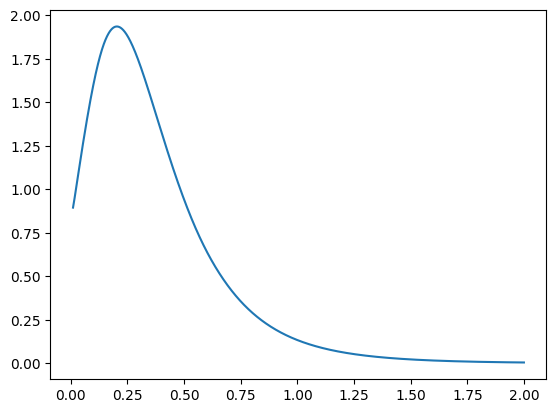

In [10]:
# noise ratio
m = model.marginal_noise_ratio_
lx = np.arange(0.01, 2.0, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median noise ratio =', m.ppf(0.5))

median sigma2-signal = 0.16103745222581256


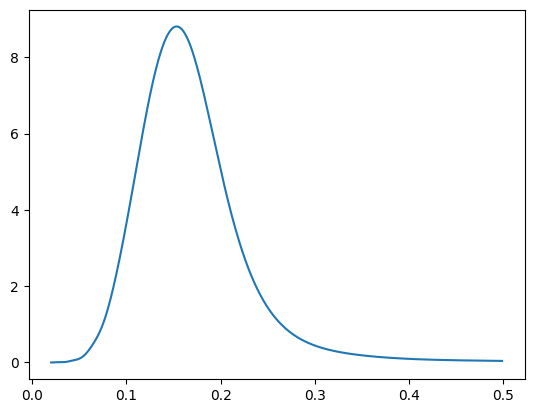

In [11]:
# signal variance
m = model.marginal_sigma2_signal_
lx = np.arange(0.02, 0.5, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median sigma2-signal =', m.ppf(0.5))

median beta_1 = 6.985303850956297


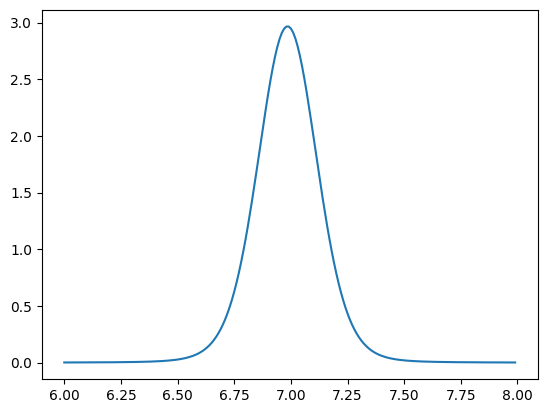

In [12]:
# regression weight 1
m = model.marginal_regressors_[0]
lx = np.arange(6, 8, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median beta_1 =', m.ppf(0.5))

median beta_2 = -2.561307115336548


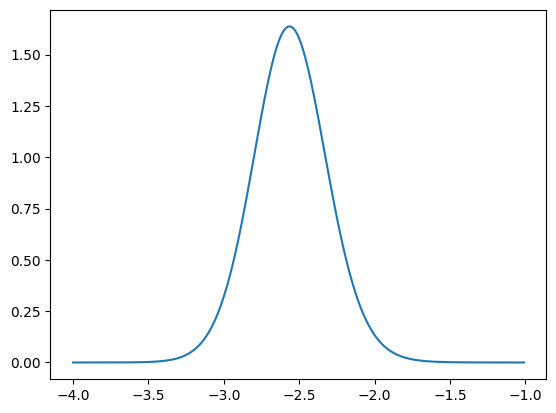

In [13]:
# regression weight 2
m = model.marginal_regressors_[1]
lx = np.arange(-4, -1, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median beta_2 =', m.ppf(0.5))

## Plot Predictions
Visualize the predicted log zinc concetrations and the associated 95% credible sets for the 3103 test locations provided by the data set.

In [14]:
pred, pred_pdfs = model.predict(Z_test, X_test, with_pdf=True)

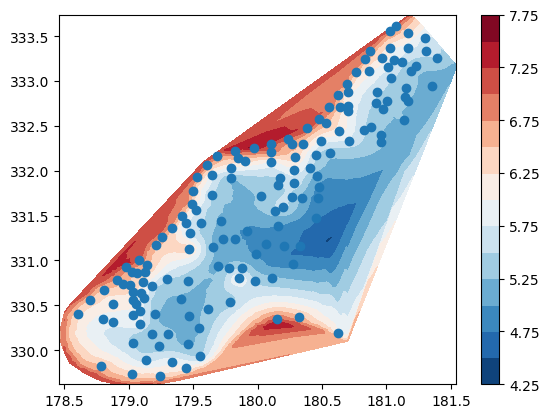

In [15]:
plt.tricontourf(Z_test[:, 0], Z_test[:, 1], pred, levels=14, cmap='RdBu_r')
plt.colorbar()
plt.scatter(Z_train[:, 0], Z_train[:, 1])

In [16]:
low = 0.025
lengths = pred_pdfs.ppf(1.0 - low) - pred_pdfs.ppf(low)

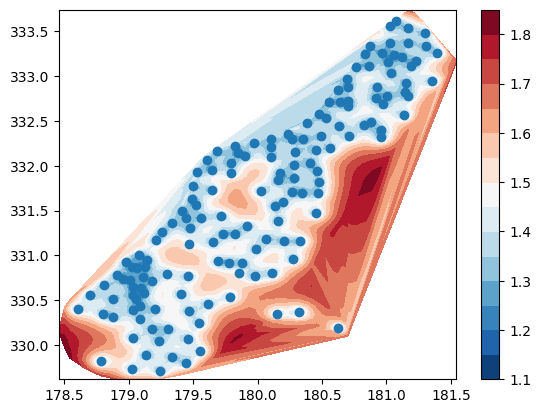

In [17]:
plt.tricontourf(Z_test[:, 0], Z_test[:, 1], lengths, levels=14, cmap='RdBu_r')
plt.colorbar()
plt.scatter(Z_train[:, 0], Z_train[:, 1])